In [ ]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import matplotlib.pyplot as plt

### Full system

The value of T_healthy at t = 365 days is 5.1990007325892424 kg
The value of T_Cushings at t = 365 days is 8.799894127979966 kg
The value of metabolism at t = 365 days is 5.398604951040006 kg
The value of skeletal muscle mass healthy at t = 365 days is 24.06928446726611 kg
The value of skeletal muscle mass Cushings at t = 365 days is 23.325669711140133 kg
The value of fat mass healthy at t = 365 days is 14.320017469910104 kg
The value of fat mass Cushings at t = 365 days is 15.776228115837986 kg


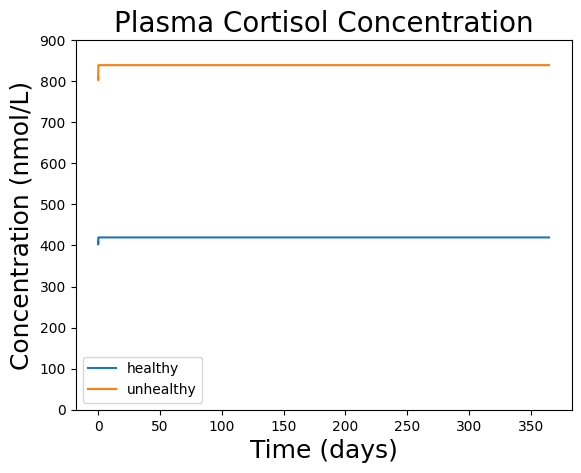

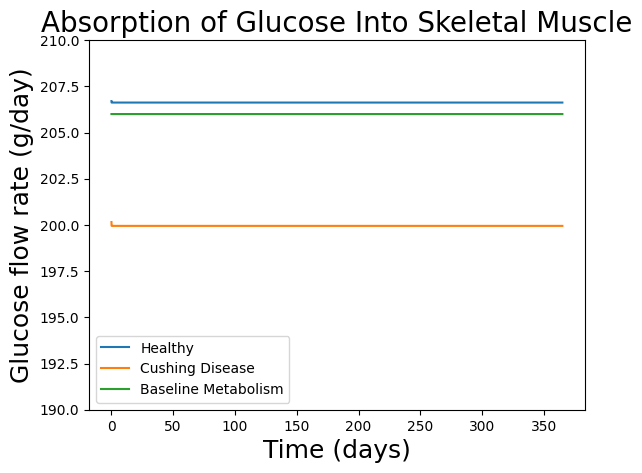

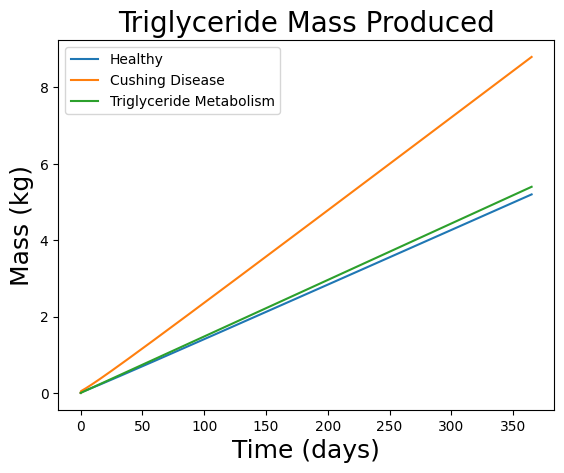

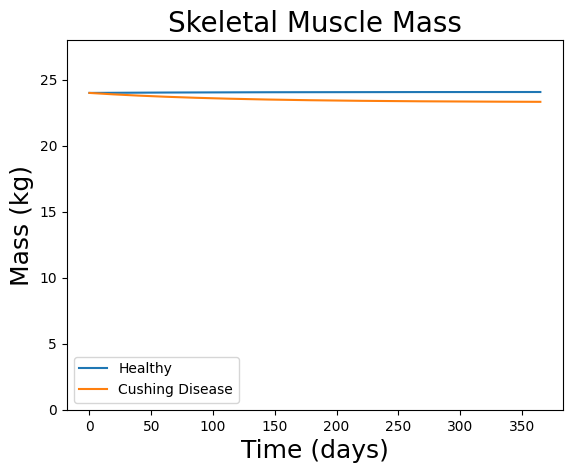

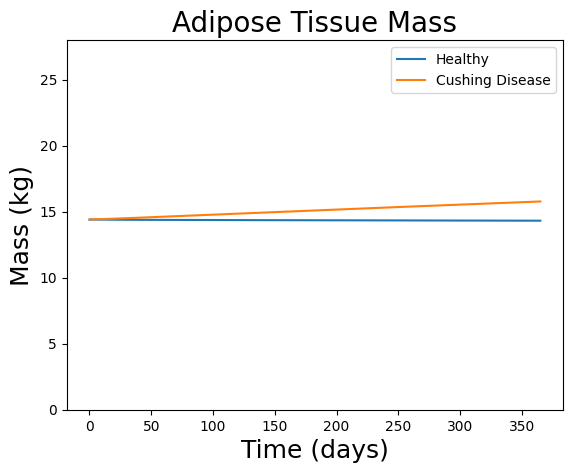

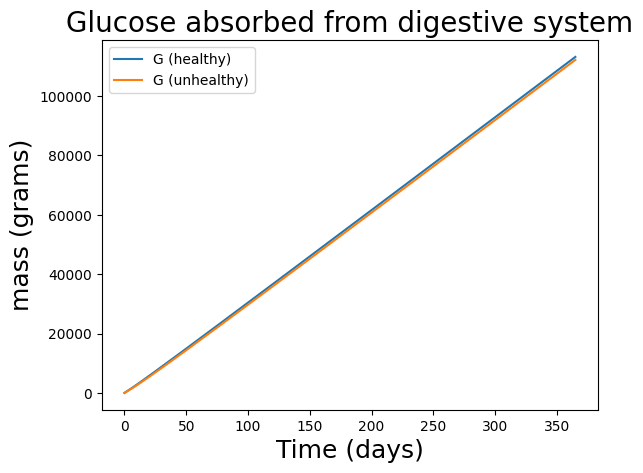

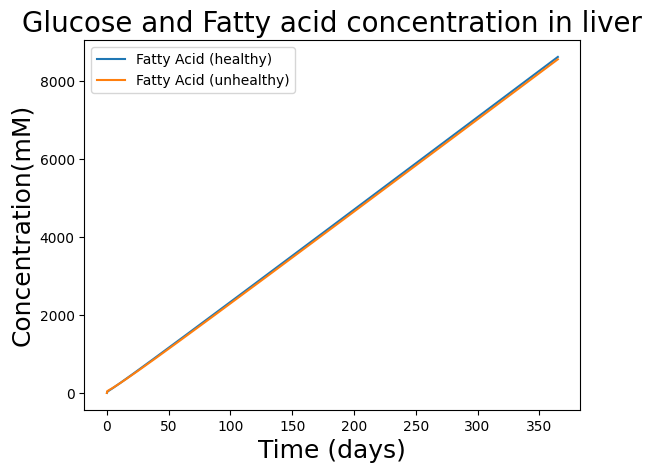

In [ ]:
# constants for cortisol and ACTH
k1 = 1.83  # this is production of ACTH from CRH
k2 = 0.036  # this is the reaction for formation of cortisol from CRH
k3 = 0.000288  # production of ALDO from ACTH
k4 = 1.26 * (10 ** 14)  # more production of CORT from ACTH
k5 = 7.05 * (10 ** 12)  # degradation of cortisol by ALDO
k6 = 0.0535  # this is production of P1 from ACTH
k8 = 0.11  # production of P3 from CRH
k9 = 0.135  # production of P4 from ALDO

# constants for skeletal muscle
k_f = 0.054 #nM/min
k_r = 1 # nM/min

#constants for digestive system
k10 = 509*.100 #mM/s, estimated such that Km is reasonable, between known values of two main transporter proteins (GLUT2 and SGLT1)
k11 = .050 #mM/s, estimated k-1
k12 = 508.79*.307 #mM/s, estimating this as rate needed to get 260 g glucose per day (converted this rate to mmol/s and divided by volume of small intestine interior, .054 L)
k13 =  300      #11000.20 #crazy value, but Saterbak approved
k33 = .050

def all_compartments(y, t):
# Extract variables
    acth, cort, CRH, ALDO, p1, p2, p3, p4, R, CR, FA, T, g, GLUT2, gGLUT2, G, C, CGLUT2, G_liver, F_liver, G_in_skeletal, G_out_skeletal, k7, abs, muscle_mass, fat_mass, fat_metabolism = y

    dCRH = 1.83 * (10 ** (-8)) - k1 * CRH - k8 * CRH
    dALDO = 6.09 * (10 ** (-11)) + k3 * acth - k5 * ALDO * cort - k9 * ALDO
    dacth_dt = k1 * CRH - k2 * acth - k3 * acth - k4 * acth * cort - k6 * acth
    dcort_dt = k2 * acth + k4 * acth * cort - k7 * cort - k5 * ALDO * cort
    dP1_dt = k6 * acth
    dP2_dt = k7 * cort
    dP3_dt = k8 * CRH
    dP4_dt = k9 * ALDO

    #equations for digestive system
    dg_dt = 60*(k11 * gGLUT2)
    dGLUT2_dt = 60*(-k10 * g * GLUT2 + k11 * gGLUT2 + k12 * gGLUT2 + k33 * CGLUT2 - k13 * GLUT2 * (cort*10**(3)))
    dgGLUT2_dt = 60*(k10 * g * GLUT2 - k11 * gGLUT2 - k12 * gGLUT2)
    dG_dt = 60*(k12 * gGLUT2) #RAHIL - CHANGED TO BE ACCURATE WITH SIMPLIFIED MODEL
    dC_dt = 60*(-k13 * (cort*10**(3)) * GLUT2 + k33 * CGLUT2)
    dCGLUT2_dt = 60*(k13 * (cort*10**(3)) * GLUT2 - k33 * CGLUT2)

    #equations for skeletal muscle
    dRecep_dt = -k_f * (cort*10**(9)/50) * R + k_r * CR
    dCR_dt = k_f * (cort*10**(9)/50) * R - k_r * CR
    dG_in_skeletal =  3.39*(10**10) * (-dCR_dt  * 10**(-9) * 22.6) #units are in g/day
    dG_out_skeletal = dg_dt - dG_in_skeletal
    dmuscle_mass = (1/(24*60))*(G_in_skeletal - 206*(muscle_mass/24000))

    #LIVER
    # multiply by 60 to convert hours into min
    dG_liverdt = dG_out_skeletal -1 *(1/60)* (1.32e-6 * 1190000 * .45 *  G_liver + 1.909e-7)
    dF_liverdt =  (1/60)*(1.32e-6 * 1190000 * G_liver + 1.909e-6)
    dG_out_liver = 0

    #equation for adipose tissue
    dabs = 0
    dTdt = (abs * 3*  dF_liverdt)
    dfat_mass = dTdt - 0.0045*(fat_mass/14400)
    dfat_metabolism = 0.0045

    dk7 = 0

    return [dacth_dt, dcort_dt, dCRH, dALDO, dP1_dt, dP2_dt, dP3_dt, dP4_dt, dRecep_dt, dCR_dt, FA, dTdt, dg_dt, dGLUT2_dt, dgGLUT2_dt, dG_dt, dC_dt, dCGLUT2_dt, dG_liverdt, dF_liverdt, dG_in_skeletal, dG_out_skeletal, dk7, dabs, dmuscle_mass, dfat_mass, dfat_metabolism]

initial_conditions = {
    "acth_0": 0,  # Initial condition for ACTH
    "cort_0": 410e-9,  # Initial condition for cortisol (200 nM)
    "CRH_0": 0,  # Initial condition for CRH
    "ALDO_0": 0,  # Initial condition for ALDO
    "p1_0": 0,  # Initial condition for p1
    "p2_0": 0,  # Initial condition for p2
    "p3_0": 0,  # Initial condition for p3
    "p4_0": 0,  # Initial condition for p4

    "Receptor0": 0.052750,  # Initial concentration of GC receptors in skeletal muscle (nM)
    "C0": 5e-4,  # Initial concentration of cortisol in skeletal muscle

    "FA0": 0,  # Initial concentration of fatty acids in adipose tissue
    "T0": 0,  # Initial concentration of triglycerides in adipose tissue

    "g0": 48,  # Initial concentration of ingested glucose in digestive system
    "GLUT20": 0.002485,  # Initial concentration of GLUT2 in digestive system
    "gGLUT20": 0,  # Initial concentration of GLUT2-glucose complex in digestive system
    "G0": 0,  # Initial concentration of glucose in digestive system
    "C00": 0,  # Initial concentration of cortisol in digestive system
    "CGLUT20": 0,  # Initial concentration of GLUT2-cortisol complex in digestive system

    "G_liver": 0,  # Initial concentration of glucose in liver
    "F_liver": 0,  # Initial concentration of fructose in liver

    "G_in_skeletal0": 3.39e10 * (6.12e-9 + 0.015e-9 * 22.6),  # Initial concentration of glucose entering skeletal muscle
    "G_out_skeletal0": 0,  # Initial concentration of glucose leaving skeletal muscle

    "k7": 0.0410,  # this is production of P2 from cortisol, original = 0.410
    "abs" : .088,
    "muscle_mass": 24000, # 24 kg muscle mass (40% of 60 kg)
    "fat_mass": 14400, # 14.4 kg fat mass (24.4% of 60 kg)
    "fat_metabolism": 0 # amount of triglyceride consumed to maintain mass
}

# Populate the array using the dictionary
y0 = np.array([initial_conditions[key] for key in initial_conditions])

#Unhealthy initial conditions
initial_conditions_unhealthy = initial_conditions.copy()  # Copying from healthy
initial_conditions_unhealthy['k7'] = 0.0410/2  # Modify the specific condition you want to change
initial_conditions_unhealthy['cort_0'] = 810e-9
initial_conditions_unhealthy['abs'] = .15



# Populate the array using the dictionary for the "unhealthy" run
y0_unhealthy = np.array([initial_conditions_unhealthy[key] for key in initial_conditions_unhealthy])

t_span = np.linspace(0, 365*24*60, 365*24*60)

full_system_healthy = odeint(all_compartments, y0, t_span)
acth_healthy, cort_healthy, CRH_healthy, ALDO_healthy, p1_healthy, p2_healthy, p3_healthy, p4_healthy, R_healthy, CR_healthy, FA_healthy, T_healthy, g_healthy, GLUT2_healthy, gGLUT2_healthy, G_healthy, C_healthy, CGLUT2_healthy, G_liver_healthy, F_liver_healthy, G_in_skeletal_healthy, G_out_skeletal_healthy, k7_healthy, dabs_healthy, muscle_mass_healthy, fat_mass_healthy, fat_metabolism_healthy  = full_system_healthy.T

# Integrate the system for the "unhealthy" run
full_system_unhealthy = odeint(all_compartments, y0_unhealthy, t_span)
# Unpack the results for the "unhealthy" run
acth_unhealthy, cort_unhealthy, CRH_unhealthy, ALDO_unhealthy, p1_unhealthy, p2_unhealthy, p3_unhealthy, p4_unhealthy, R_unhealthy, CR_unhealthy, FA_unhealthy, T_unhealthy, g_unhealthy, GLUT2_unhealthy, gGLUT2_unhealthy, G_unhealthy, C_unhealthy, CGLUT2_unhealthy, G_liver_unhealthy, F_liver_unhealthy, G_in_skeletal_unhealthy, G_out_skeletal_unhealthy,k7_unhealthy, dabs, muscle_mass_unhealthy, fat_mass_unhealthy, fat_metabolism_unhealthy = full_system_unhealthy.T

baseline_G_in_skeletal = np.full(len(G_in_skeletal_healthy), 206)

t_span_days = t_span/(24*60)

# cortisol levels
fig = plt.figure(1)
plt.figure(1)
plt.plot(t_span_days, cort_healthy * (10**9), label='healthy')
plt.plot(t_span_days, cort_unhealthy * (10**9), label='unhealthy')
plt.xlabel('Time (days)', size=18)
plt.ylabel('Concentration (nmol/L)', size=18)
plt.ylim((0, 900))
plt.legend()
plt.title('Plasma Cortisol Concentration', size=20)
plt.ticklabel_format(axis='y', style='plain')


plt.figure(2)
plt.plot(t_span_days[40:], G_in_skeletal_healthy[40:], label='Healthy')
plt.plot(t_span_days[40:], G_in_skeletal_unhealthy[40:], label='Cushing Disease')
plt.plot(t_span_days[40:], baseline_G_in_skeletal[40:], label = "Baseline Metabolism", linestyle='--')
plt.xlabel('Time (days)', size=18)
plt.ylim((190, 210))
plt.ylabel('Glucose flow rate (g/day)', size=18)
plt.title('Absorption of Glucose Into Skeletal Muscle', size=20)
plt.ticklabel_format(axis='y', style='plain')
plt.legend()


plt.figure(3)
plt.plot(t_span_days, T_healthy*176.12*12.96/(1000*1000), label='Healthy')
plt.plot(t_span_days, T_unhealthy*176.12*12.96/(1000*1000), label='Cushing Disease')
plt.plot(t_span_days, fat_metabolism_healthy*176.12*12.96/(1000*1000), label = "Triglyceride Metabolism", linestyle='--')
plt.xlabel('Time (days)', size=18)
plt.ylabel('Mass (kg)', size=18)
plt.title('Triglyceride Mass Produced', size = 20)
plt.ticklabel_format(axis='y', style='plain')
plt.legend()


#Find values at 365 days
from scipy.interpolate import interp1d

# Create an interpolation function for T
T_interp = interp1d(t_span_days, T_healthy*176.12*12.96/(1000*1000))
# Find the value of G at t = 365 days
T_healthy_365days = T_interp(365)
print(f"The value of T_healthy at t = 365 days is {T_healthy_365days} kg")

# Create an interpolation function for T
T_interp2 = interp1d(t_span_days, T_unhealthy*176.12*12.96/(1000*1000))
# Find the value of G at t = 365 days
T_Cushings_365days = T_interp2(365)
print(f"The value of T_Cushings at t = 365 days is {T_Cushings_365days} kg")

# Create an interpolation function for T
T_interp3 = interp1d(t_span_days, fat_metabolism_healthy*176.12*12.96/(1000*1000))
# Find the value of G at t = 365 days
Metabolism_365days = T_interp3(365)
print(f"The value of metabolism at t = 365 days is {Metabolism_365days} kg")

plt.figure(4)
plt.plot(t_span_days, (muscle_mass_healthy)/1000, label = "Healthy")
plt.plot(t_span_days, (muscle_mass_unhealthy)/1000, label = "Cushing Disease")
plt.xlabel("Time (days)", size=18)
plt.ylim((0, 28))
plt.ylabel("Mass (kg)", size=18)
plt.legend()
plt.title("Skeletal Muscle Mass", size=20)
plt.savefig('Skeletal_MM.png', dpi=300)
plt.ticklabel_format(axis='y', style='plain')


# Create an interpolation function for f
S_interp = interp1d(t_span_days, (muscle_mass_healthy)/1000)
# Find the value of f at t = 365 days
Skeletal_mass_healthy_365days = S_interp(365)
print(f"The value of skeletal muscle mass healthy at t = 365 days is {Skeletal_mass_healthy_365days} kg")

# Create an interpolation function for T
S_interp2 = interp1d(t_span_days, (muscle_mass_unhealthy)/1000)
# Find the value of f at t = 365 days
Skeletal_mass_unhealthy_365days = S_interp2(365)
print(f"The value of skeletal muscle mass Cushings at t = 365 days is {Skeletal_mass_unhealthy_365days} kg")


plt.figure(5)
plt.plot(t_span_days, fat_mass_healthy/1000, label = "Healthy")
plt.plot(t_span_days, fat_mass_unhealthy/1000, label = "Cushing Disease")
plt.xlabel("Time (days)", size=18)
plt.ylim((0, 28))
plt.ylabel("Mass (kg)", size=18)
plt.legend()
plt.title("Adipose Tissue Mass", size=20)
plt.savefig('Adipose_TM.png', dpi=300)
plt.ticklabel_format(axis='y', style='plain')

# Create an interpolation function for f
f_interp = interp1d(t_span_days, fat_mass_healthy/1000)
# Find the value of f at t = 365 days
fat_mass_healthy_365days = f_interp(365)
print(f"The value of fat mass healthy at t = 365 days is {fat_mass_healthy_365days} kg")

# Create an interpolation function for T
f_interp2 = interp1d(t_span_days, fat_mass_unhealthy/1000)
# Find the value of f at t = 365 days
fat_mass_Cushings_365days = f_interp2(365)
print(f"The value of fat mass Cushings at t = 365 days is {fat_mass_Cushings_365days} kg")


plt.figure(6)
plt.plot(t_span_days, (G_healthy*180*5.2)/100000, label="G (healthy)")
plt.plot(t_span_days, (G_unhealthy*180*5.2)/100000, label="G (unhealthy)")
plt.xlabel("Time (days)", size=18)
plt.ylabel("mass (grams)", size=18)
plt.title("Glucose absorbed from digestive system", size=20)
plt.legend()
plt.ticklabel_format(axis='y', style='plain')

plt.figure(7)
plt.plot(t_span_days, F_liver_healthy, label='Fatty Acid (healthy)')
plt.plot(t_span_days, F_liver_unhealthy, label='Fatty Acid (unhealthy)')
plt.xlabel('Time (days)', size=18)
plt.ylabel('Concentration(mM)', size=18)
plt.title('Glucose and Fatty acid concentration in liver', size=20)
plt.ticklabel_format(axis='y', style='plain')
plt.legend()


plt.show()


### Panic attack

#### old

Time for cortisol to drop below 450 nmol/L: 54.03752605976372 minutes


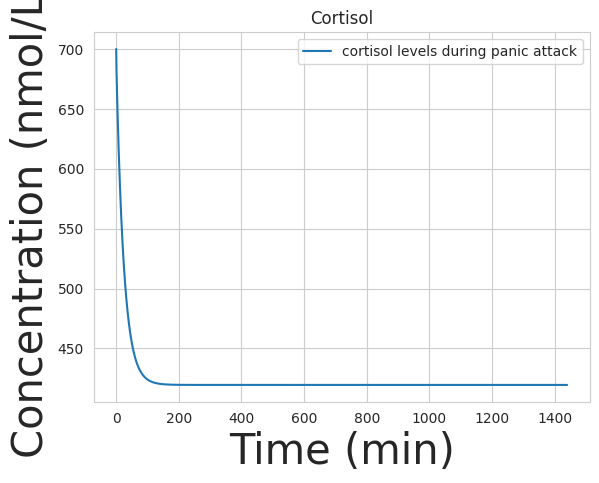

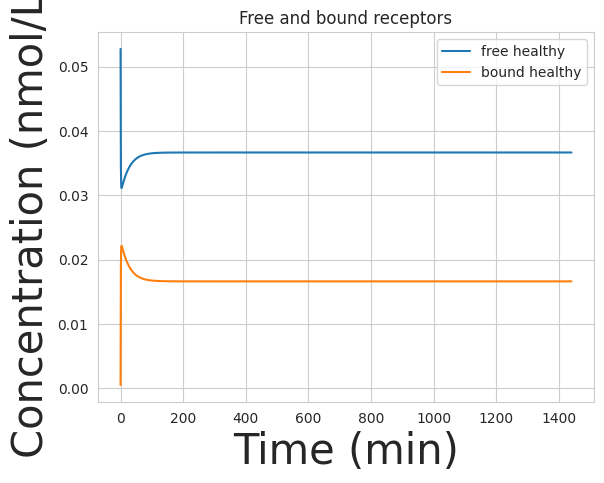

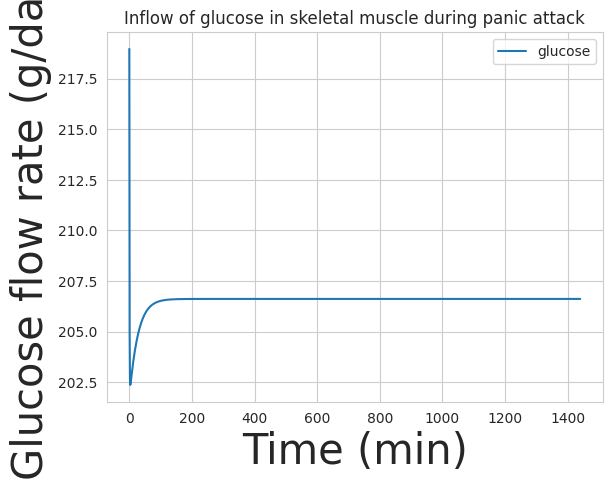

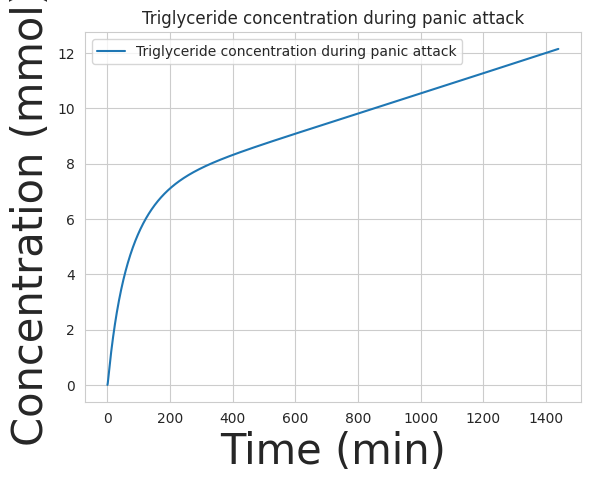

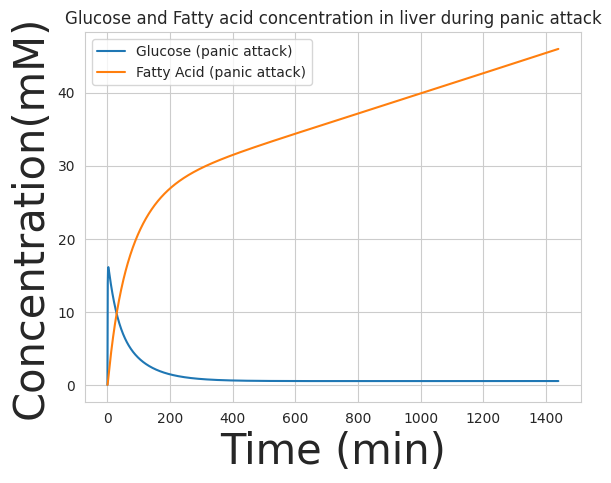

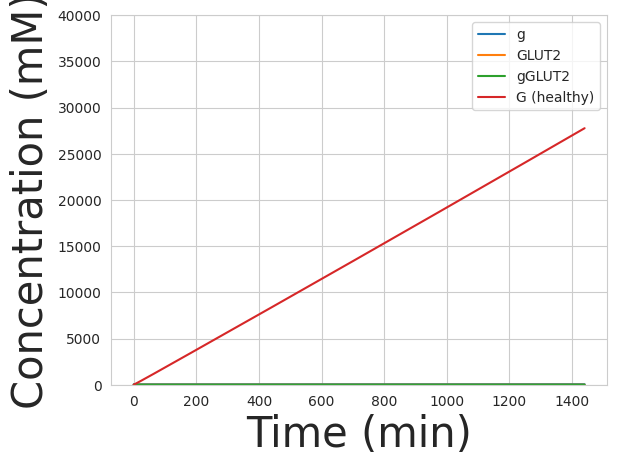

In [ ]:
# constants for cortisol and ACTH
k1 = 1.83  # this is production of ACTH from CRH
k2 = 0.036  # this is the reaction for formation of cortisol from CRH
k3 = 0.000288  # production of ALDO from ACTH
k4 = 1.26 * (10 ** 14)  # more production of CORT from ACTH
k5 = 7.05 * (10 ** 12)  # degradation of cortisol by ALDO
k6 = 0.0535  # this is production of P1 from ACTH
k8 = 0.11  # production of P3 from CRH
k9 = 0.135  # production of P4 from ALDO

# constants for skeletal muscle
k_f = 0.054 #nM/min
k_r = 1 # nM/min

#constants for digestive system
k10 = 509*.100 #mM/s, estimated such that Km is reasonable, between known values of two main transporter proteins (GLUT2 and SGLT1)
k11 = .050 #mM/s, estimated k-1
k12 = 508.79*.307 #mM/s, estimating this as rate needed to get 260 g glucose per day (converted this rate to mmol/s and divided by volume of small intestine interior, .054 L)
k13 =  300      #11000.20 #crazy value, but Saterbak approved
k33 = .050

def all_compartments(y, t):
# Extract variables
    acth, cort, CRH, ALDO, p1, p2, p3, p4, R, CR, FA, T, g, GLUT2, gGLUT2, G, C, CGLUT2, G_liver, F_liver, G_in_skeletal, G_out_skeletal, k7 = y

    dCRH = 1.83 * (10 ** (-8)) - k1 * CRH - k8 * CRH
    dALDO = 6.09 * (10 ** (-11)) + k3 * acth - k5 * ALDO * cort - k9 * ALDO
    dacth_dt = k1 * CRH - k2 * acth - k3 * acth - k4 * acth * cort - k6 * acth
    dcort_dt = k2 * acth + k4 * acth * cort - k7 * cort - k5 * ALDO * cort
    dP1_dt = k6 * acth
    dP2_dt = k7 * cort
    dP3_dt = k8 * CRH
    dP4_dt = k9 * ALDO

    #equations for digestive system
    dg_dt = 60*(k11 * gGLUT2)
    dGLUT2_dt = 60*(-k10 * g * GLUT2 + k11 * gGLUT2 + k12 * gGLUT2 + k33 * CGLUT2 - k13 * GLUT2 * (cort*10**(3)))
    dgGLUT2_dt = 60*(k10 * g * GLUT2 - k11 * gGLUT2 - k12 * gGLUT2)
    dG_dt = 60*(k12 * gGLUT2) #RAHIL - CHANGED TO BE ACCURATE WITH SIMPLIFIED MODEL
    dC_dt = 60*(-k13 * (cort*10**(3)) * GLUT2 + k33 * CGLUT2)
    dCGLUT2_dt = 60*(k13 * (cort*10**(3)) * GLUT2 - k33 * CGLUT2)

    #equations for skeletal muscle
    dRecep_dt = -k_f * (cort*10**(9)/50) * R + k_r * CR
    dCR_dt = k_f * (cort*10**(9)/50) * R - k_r * CR
    dG_in_skeletal =  3.39*(10**10) * (-dCR_dt  * 10**(-9) * 22.6) #units are in g/day
    dG_out_skeletal = dg_dt - dG_in_skeletal

    #LIVER
    # multiply by 60 to convert hours into min
    dG_liverdt = dG_out_skeletal -1 *(1/60)* (1.32e-6 * 1190000 * .45 *  G_liver + 1.909e-7)
    dF_liverdt =  (1/60)*(1.32e-6 * 1190000 * G_liver + 1.909e-6)
    dG_out_liver = 0

    #equation for adipose tissue
    dTdt = (0.088 * 3*  dF_liverdt)

    dk7 = 0

    return [dacth_dt, dcort_dt, dCRH, dALDO, dP1_dt, dP2_dt, dP3_dt, dP4_dt, dRecep_dt, dCR_dt, FA, dTdt, dg_dt, dGLUT2_dt, dgGLUT2_dt, dG_dt, dC_dt, dCGLUT2_dt, dG_liverdt, dF_liverdt, dG_in_skeletal, dG_out_skeletal, dk7]

initial_conditions = {
    "acth_0": 0,  # Initial condition for ACTH
    "cort_0": 700e-9,  # Initial condition for cortisol (200 nM)
    "CRH_0": 0,  # Initial condition for CRH
    "ALDO_0": 0,  # Initial condition for ALDO
    "p1_0": 0,  # Initial condition for p1
    "p2_0": 0,  # Initial condition for p2
    "p3_0": 0,  # Initial condition for p3
    "p4_0": 0,  # Initial condition for p4

    "Receptor0": 0.052750,  # Initial concentration of GC receptors in skeletal muscle (nM)
    "C0": 5e-4,  # Initial concentration of cortisol in skeletal muscle

    "FA0": 0,  # Initial concentration of fatty acids in adipose tissue
    "T0": 0,  # Initial concentration of triglycerides in adipose tissue

    "g0": 48,  # Initial concentration of ingested glucose in digestive system
    "GLUT20": 0.002485,  # Initial concentration of GLUT2 in digestive system
    "gGLUT20": 0,  # Initial concentration of GLUT2-glucose complex in digestive system
    "G0": 0,  # Initial concentration of glucose in digestive system
    "C00": 0,  # Initial concentration of cortisol in digestive system
    "CGLUT20": 0,  # Initial concentration of GLUT2-cortisol complex in digestive system

    "G_liver": 0,  # Initial concentration of glucose in liver
    "F_liver": 0,  # Initial concentration of fructose in liver

    "G_in_skeletal0": 3.39e10 * (6.12e-9 + 0.015e-9 * 22.6),  # Initial concentration of glucose entering skeletal muscle
    "G_out_skeletal0": 0,  # Initial concentration of glucose leaving skeletal muscle

    "k7": 0.0410  # this is production of P2 from cortisol, original = 0.410
}

# Populate the array using the dictionary
y0 = np.array([initial_conditions[key] for key in initial_conditions])

#Unhealthy initial conditions
initial_conditions_unhealthy = initial_conditions.copy()  # Copying from healthy
initial_conditions_unhealthy['k7'] = 0.0410/2  # Modify the specific condition you want to change
initial_conditions_unhealthy['cort_0'] = 600e-9

# Populate the array using the dictionary for the "unhealthy" run
y0_unhealthy = np.array([initial_conditions_unhealthy[key] for key in initial_conditions_unhealthy])

t_span = np.linspace(0, 24*60, 24*60)

full_system_healthy = odeint(all_compartments, y0, t_span)
acth_healthy, cort_healthy, CRH_healthy, ALDO_healthy, p1_healthy, p2_healthy, p3_healthy, p4_healthy, R_healthy, CR_healthy, FA_healthy, T_healthy, g_healthy, GLUT2_healthy, gGLUT2_healthy, G_healthy, C_healthy, CGLUT2_healthy, G_liver_healthy, F_liver_healthy, G_in_skeletal_healthy, G_out_skeletal_healthy, dk7_healthy = full_system_healthy.T

# Integrate the system for the "unhealthy" run
full_system_unhealthy = odeint(all_compartments, y0_unhealthy, t_span)
# Unpack the results for the "unhealthy" run
acth_unhealthy, cort_unhealthy, CRH_unhealthy, ALDO_unhealthy, p1_unhealthy, p2_unhealthy, p3_unhealthy, p4_unhealthy, R_unhealthy, CR_unhealthy, FA_unhealthy, T_unhealthy, g_unhealthy, GLUT2_unhealthy, gGLUT2_unhealthy, G_unhealthy, C_unhealthy, CGLUT2_unhealthy, G_liver_unhealthy, F_liver_unhealthy, G_in_skeletal_unhealthy, G_out_skeletal_unhealthy, dk7_unhealthy = full_system_unhealthy.T

# cortisol levels
time_below_450 = t_span[np.where((full_system_healthy[:, 1] * (10**9)) < 450)[0][0]]
print("Time for cortisol to drop below 450 nmol/L:", time_below_450, "minutes")

plt.figure(1)
plt.plot(t_span, cort_healthy * (10**9), label='cortisol levels during panic attack')
plt.xlabel('Time (min)', size=30)
plt.ylabel('Concentration (nmol/L)', size=30)
plt.legend()
plt.title('Cortisol')
plt.ticklabel_format(axis='y', style='plain')


# calculating glucose flow rate in skeletal muscle
plt.figure(2)
plt.plot(t_span, R_healthy , label='free healthy')
plt.plot(t_span, CR_healthy, label='bound healthy')
# plt.plot(t_span, R_unhealthy, label='free unhealthy')
# plt.plot(t_span, CR_unhealthy, label='bound unhealthy')
plt.xlabel('Time (min)', size=30)
plt.ylabel('Concentration (nmol/L)', size=30)
plt.title('Free and bound receptors')
plt.legend()


plt.figure(3)
plt.plot(t_span, G_in_skeletal_healthy, label='glucose')
# plt.plot(t_span, G_in_skeletal_unhealthy, label='unhealthy')
plt.xlabel('Time (min)', size=30)
plt.ylabel('Glucose flow rate (g/day)', size=30)
plt.title('Inflow of glucose in skeletal muscle during panic attack')
plt.legend()


plt.figure(4)
plt.plot(t_span, T_healthy, label='Triglyceride concentration during panic attack')
# plt.plot(t_span, T_unhealthy, label='unhealthy')
plt.xlabel('Time (min)', size=30)
plt.ylabel('Concentration (mmol)', size=30)
plt.title('Triglyceride concentration during panic attack')
plt.legend()


plt.figure(5)
plt.plot(t_span, G_liver_healthy, label='Glucose (panic attack)')
plt.plot(t_span, F_liver_healthy, label='Fatty Acid (panic attack)')
# plt.plot(t_span, G_liver_unhealthy, label='Glucose (unhealthy)')
# plt.plot(t_span, F_liver_unhealthy, label='Fatty Acid (unhealthy)')
plt.xlabel('Time (min)', size=30)
plt.ylabel('Concentration(mM)', size=30)
plt.title('Glucose and Fatty acid concentration in liver during panic attack')
plt.legend()

plt.figure(6)
plt.plot(t_span, g_healthy, label="g")
plt.plot(t_span, GLUT2_healthy, label="GLUT2")
plt.plot(t_span, gGLUT2_healthy, label="gGLUT2")
plt.plot(t_span, G_healthy, label="G (healthy)")
# plt.plot(t_span, G_unhealthy, label="G (unhealthy)")
plt.xlabel("Time (min)", size=30)
plt.ylim((0, 40000))
plt.ylabel("Concentration (mM)", size=30)
plt.legend()
plt.show()

plt.show()


#### New stimulus

panic attack lasts (levels of cortisol are above 450 nmol/L): 37.02571230020851 min
Min rate of absorption of  glucose into skeletal muscle is 200.8652142922224


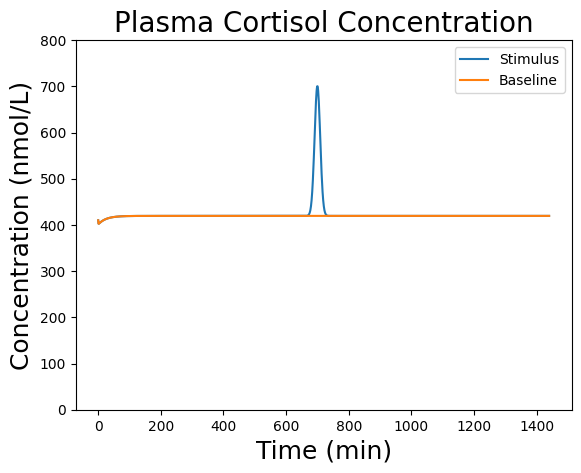

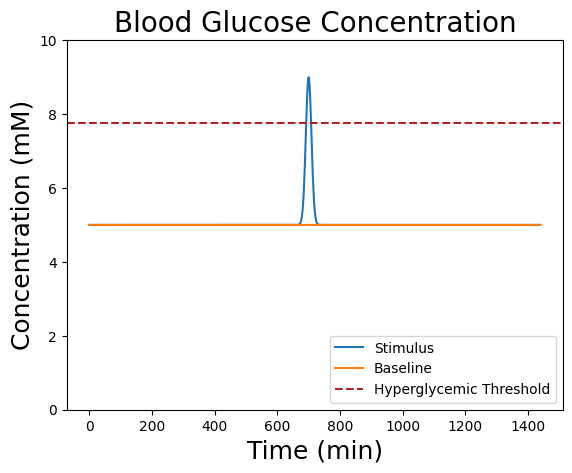

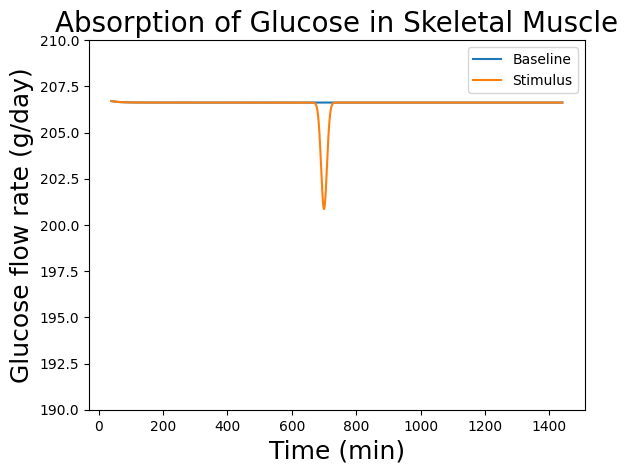

In [ ]:
# constants for cortisol and ACTH
k1 = 1.83  # this is production of ACTH from CRH
k2 = 0.036  # this is the reaction for formation of cortisol from CRH
k3 = 0.000288  # production of ALDO from ACTH
k4 = 1.26 * (10 ** 14)  # more production of CORT from ACTH
k5 = 7.05 * (10 ** 12)  # degradation of cortisol by ALDO
k6 = 0.0535  # this is production of P1 from ACTH
k8 = 0.11  # production of P3 from CRH
k9 = 0.135  # production of P4 from ALDO

# constants for skeletal muscle
k_f = 0.054 #nM/min
k_r = 1 # nM/min

#constants for digestive system
k10 = 509*.100 #mM/s, estimated such that Km is reasonable, between known values of two main transporter proteins (GLUT2 and SGLT1)
k11 = .050 #mM/s, estimated k-1
k12 = 508.79*.307 #mM/s, estimating this as rate needed to get 260 g glucose per day (converted this rate to mmol/s and divided by volume of small intestine interior, .054 L)
k13 =  300      #11000.20 #crazy value, but Saterbak approved
k33 = .050

def all_compartments(y, t):
# Extract variables
    acth, cort, CRH, ALDO, p1, p2, p3, p4, R, CR, FA, T, g, GLUT2, gGLUT2, G, C, CGLUT2, G_liver, F_liver, G_in_skeletal, G_out_skeletal, k7 = y

    dCRH = 1.83 * (10 ** (-8)) - k1 * CRH - k8 * CRH
    dALDO = 6.09 * (10 ** (-11)) + k3 * acth - k5 * ALDO * cort - k9 * ALDO
    dacth_dt = k1 * CRH - k2 * acth - k3 * acth - k4 * acth * cort - k6 * acth
    dcort_dt = k2 * acth + k4 * acth * cort - k7 * cort - k5 * ALDO * cort
    dP1_dt = k6 * acth
    dP2_dt = k7 * cort
    dP3_dt = k8 * CRH
    dP4_dt = k9 * ALDO

    #equations for digestive system
    dg_dt = 60*(k11 * gGLUT2)
    dGLUT2_dt = 60*(-k10 * g * GLUT2 + k11 * gGLUT2 + k12 * gGLUT2 + k33 * CGLUT2 - k13 * GLUT2 * (cort*10**(3)))
    dgGLUT2_dt = 60*(k10 * g * GLUT2 - k11 * gGLUT2 - k12 * gGLUT2)
    dG_dt = 60*(k12 * gGLUT2) #RAHIL - CHANGED TO BE ACCURATE WITH SIMPLIFIED MODEL
    dC_dt = 60*(-k13 * (cort*10**(3)) * GLUT2 + k33 * CGLUT2)
    dCGLUT2_dt = 60*(k13 * (cort*10**(3)) * GLUT2 - k33 * CGLUT2)

    #equations for skeletal muscle
    dRecep_dt = -k_f * (cort*10**(9)/50) * R + k_r * CR
    dCR_dt = k_f * (cort*10**(9)/50) * R - k_r * CR
    dG_in_skeletal =  3.39*(10**10) * (-dCR_dt  * 10**(-9) * 22.6) #units are in g/day
    dG_out_skeletal = dg_dt - dG_in_skeletal

    #LIVER
    # multiply by 60 to convert hours into min
    dG_liverdt = dG_out_skeletal -1 *(1/60)* (1.32e-6 * 1190000 * .45 *  G_liver + 1.909e-7)
    dF_liverdt =  (1/60)*(1.32e-6 * 1190000 * G_liver + 1.909e-6)
    dG_out_liver = 0

    #equation for adipose tissue
    dTdt = (0.088 * 3*  dF_liverdt)

    dk7 = 0

    return [dacth_dt, dcort_dt, dCRH, dALDO, dP1_dt, dP2_dt, dP3_dt, dP4_dt, dRecep_dt, dCR_dt, FA, dTdt, dg_dt, dGLUT2_dt, dgGLUT2_dt, dG_dt, dC_dt, dCGLUT2_dt, dG_liverdt, dF_liverdt, dG_in_skeletal, dG_out_skeletal, dk7]

initial_conditions = {
    "acth_0": 0,  # Initial condition for ACTH
    "cort_0": 410e-9,  # Initial condition for cortisol (200 nM)
    "CRH_0": 0,  # Initial condition for CRH
    "ALDO_0": 0,  # Initial condition for ALDO
    "p1_0": 0,  # Initial condition for p1
    "p2_0": 0,  # Initial condition for p2
    "p3_0": 0,  # Initial condition for p3
    "p4_0": 0,  # Initial condition for p4

    "Receptor0": 0.052750,  # Initial concentration of GC receptors in skeletal muscle (nM)
    "C0": 5e-4,  # Initial concentration of cortisol in skeletal muscle

    "FA0": 0,  # Initial concentration of fatty acids in adipose tissue
    "T0": 0,  # Initial concentration of triglycerides in adipose tissue

    "g0": 48,  # Initial concentration of ingested glucose in digestive system
    "GLUT20": 0.002485,  # Initial concentration of GLUT2 in digestive system
    "gGLUT20": 0,  # Initial concentration of GLUT2-glucose complex in digestive system
    "G0": 0,  # Initial concentration of glucose in digestive system
    "C00": 0,  # Initial concentration of cortisol in digestive system
    "CGLUT20": 0,  # Initial concentration of GLUT2-cortisol complex in digestive system

    "G_liver": 0,  # Initial concentration of glucose in liver
    "F_liver": 0,  # Initial concentration of fructose in liver

    "G_in_skeletal0": 3.39e10 * (6.12e-9 + 0.015e-9 * 22.6),  # Initial concentration of glucose entering skeletal muscle
    "G_out_skeletal0": 0,  # Initial concentration of glucose leaving skeletal muscle

    "k7": 0.0410  # this is production of P2 from cortisol, original = 0.410
}

y0 = np.array([initial_conditions[key] for key in initial_conditions])

t_span = np.linspace(0, 24*60, 24*60)

full_system_healthy = odeint(all_compartments, y0, t_span)
acth_healthy, cort_healthy, CRH_healthy, ALDO_healthy, p1_healthy, p2_healthy, p3_healthy, p4_healthy, R_healthy, CR_healthy, FA_healthy, T_healthy, g_healthy, GLUT2_healthy, gGLUT2_healthy, G_healthy, C_healthy, CGLUT2_healthy, G_liver_healthy, F_liver_healthy, G_in_skeletal_healthy, G_out_skeletal_healthy, dk7_healthy = full_system_healthy.T


def gaussian_peak(t, t_peak, amplitude, sigma):
    return amplitude * np.exp(-((t - t_peak) ** 2) / (2 * sigma ** 2))

# Parameters for the peak
t_peak = 700  # Peak in the middle of the plot
amplitude = 281  # Adjust peak height as needed
sigma = 9.0  # Adjust peak width as needed
stimulus = cort_healthy * (10**9) + gaussian_peak(t_span, t_peak, amplitude, sigma)


above_threshold_indices = np.where(stimulus > 450)[0]
time_above_threshold = 0
for i in range(len(above_threshold_indices) - 1):
    time_interval = t_span[above_threshold_indices[i + 1]] - t_span[above_threshold_indices[i]]
    time_above_threshold += time_interval
print("panic attack lasts (levels of cortisol are above 450 nmol/L):", time_above_threshold, "min")

#blood glucose:
t_peak_g = 700  # Peak in the middle of the plot
amplitude_g = 4  # Adjust peak height as needed
sigma_g = 9.0  # Adjust peak width as needed
baseline_g = np.ones_like(t_span) * 5
glucose_pa = baseline_g + gaussian_peak(t_span, t_peak_g, amplitude_g, sigma_g)

#flow rate in skeletal muscle
flow_pa = gaussian_peak(t_span, t_peak_g, amplitude_g, sigma_g)
flow_pa = flow_pa * 10 * 180.156 * (1/1000) * 24

plt.figure(1)
plt.plot(t_span, stimulus, label='Stimulus')
plt.plot(t_span, cort_healthy * (10**9), label='Baseline')
plt.xlabel('Time (min)', size = 18)
plt.ylabel('Concentration (nmol/L)', size = 18)
plt.legend(loc='best')
plt.title('Plasma Cortisol Concentration', size = 20)
plt.ticklabel_format(axis='y', style='plain')
plt.ylim((0, 800))

plt.figure(2)
plt.plot(t_span, glucose_pa, label='Stimulus')
plt.plot(t_span, baseline_g, label='Baseline')
plt.axhline(y = 7.77, linestyle = "dashed", color = "firebrick", label = "Hyperglycemic Threshold", xmin=0, xmax=1140)
plt.xlabel('Time (min)', size = 18)
plt.ylabel('Concentration (mM)', size = 18)
plt.legend(loc='lower right')
plt.title('Blood Glucose Concentration', size = 20)
plt.ticklabel_format(axis='y', style='plain')
plt.ylim((0, 10))


plt.figure(3)
plt.plot(t_span[40:], G_in_skeletal_healthy[40:], label='Baseline')
plt.plot(t_span[40:], G_in_skeletal_healthy[40:] - (flow_pa[40:]*(1/30)), label='Stimulus')
plt.xlabel('Time (min)', size = 18)
plt.ylim((190, 210))

plt.ylabel('Glucose flow rate (g/day)', size = 18)
plt.title('Absorption of Glucose in Skeletal Muscle', size = 20)
plt.ticklabel_format(axis='y', style='plain')
plt.legend()
print(f"Min rate of absorption of  glucose into skeletal muscle is {(G_in_skeletal_healthy[40:] - (flow_pa[40:]*(1/30))).min()}")



#### time in days

panic attack lasts (levels of cortisol are above 450 nmol/L): 36.00006849328099 min


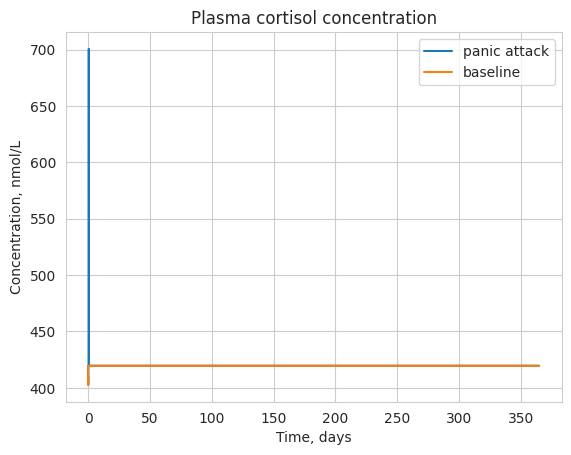

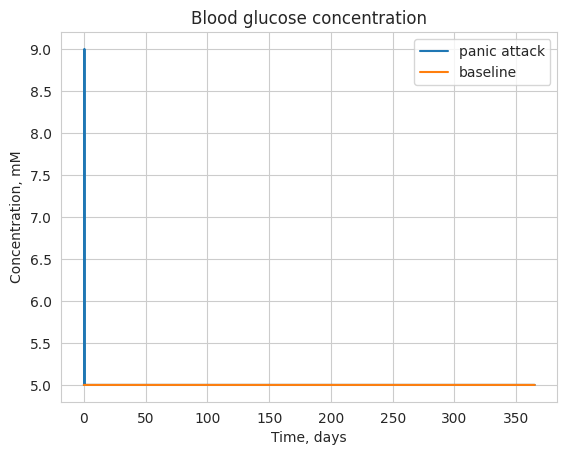

In [ ]:
t_span = np.linspace(0, 365*24*60, 365*24*60)
t_span_days = t_span/(24*60)


# constants for cortisol and ACTH
k1 = 1.83  # this is production of ACTH from CRH
k2 = 0.036  # this is the reaction for formation of cortisol from CRH
k3 = 0.000288  # production of ALDO from ACTH
k4 = 1.26 * (10 ** 14)  # more production of CORT from ACTH
k5 = 7.05 * (10 ** 12)  # degradation of cortisol by ALDO
k6 = 0.0535  # this is production of P1 from ACTH
k8 = 0.11  # production of P3 from CRH
k9 = 0.135  # production of P4 from ALDO

# constants for skeletal muscle
k_f = 0.054 #nM/min
k_r = 1 # nM/min

#constants for digestive system
k10 = 509*.100 #mM/s, estimated such that Km is reasonable, between known values of two main transporter proteins (GLUT2 and SGLT1)
k11 = .050 #mM/s, estimated k-1
k12 = 508.79*.307 #mM/s, estimating this as rate needed to get 260 g glucose per day (converted this rate to mmol/s and divided by volume of small intestine interior, .054 L)
k13 =  300      #11000.20 #crazy value, but Saterbak approved
k33 = .050

def all_compartments(y, t):
# Extract variables
    acth, cort, CRH, ALDO, p1, p2, p3, p4, R, CR, FA, T, g, GLUT2, gGLUT2, G, C, CGLUT2, G_liver, F_liver, G_in_skeletal, G_out_skeletal, k7 = y

    dCRH = 1.83 * (10 ** (-8)) - k1 * CRH - k8 * CRH
    dALDO = 6.09 * (10 ** (-11)) + k3 * acth - k5 * ALDO * cort - k9 * ALDO
    dacth_dt = k1 * CRH - k2 * acth - k3 * acth - k4 * acth * cort - k6 * acth
    dcort_dt = k2 * acth + k4 * acth * cort - k7 * cort - k5 * ALDO * cort
    dP1_dt = k6 * acth
    dP2_dt = k7 * cort
    dP3_dt = k8 * CRH
    dP4_dt = k9 * ALDO

    #equations for digestive system
    dg_dt = 60*(k11 * gGLUT2)
    dGLUT2_dt = 60*(-k10 * g * GLUT2 + k11 * gGLUT2 + k12 * gGLUT2 + k33 * CGLUT2 - k13 * GLUT2 * (cort*10**(3)))
    dgGLUT2_dt = 60*(k10 * g * GLUT2 - k11 * gGLUT2 - k12 * gGLUT2)
    dG_dt = 60*(k12 * gGLUT2) #RAHIL - CHANGED TO BE ACCURATE WITH SIMPLIFIED MODEL
    dC_dt = 60*(-k13 * (cort*10**(3)) * GLUT2 + k33 * CGLUT2)
    dCGLUT2_dt = 60*(k13 * (cort*10**(3)) * GLUT2 - k33 * CGLUT2)

    #equations for skeletal muscle
    dRecep_dt = -k_f * (cort*10**(9)/50) * R + k_r * CR
    dCR_dt = k_f * (cort*10**(9)/50) * R - k_r * CR
    dG_in_skeletal =  3.39*(10**10) * (-dCR_dt  * 10**(-9) * 22.6) #units are in g/day
    dG_out_skeletal = dg_dt - dG_in_skeletal

    #LIVER
    # multiply by 60 to convert hours into min
    dG_liverdt = dG_out_skeletal -1 *(1/60)* (1.32e-6 * 1190000 * .45 *  G_liver + 1.909e-7)
    dF_liverdt =  (1/60)*(1.32e-6 * 1190000 * G_liver + 1.909e-6)
    dG_out_liver = 0

    #equation for adipose tissue
    dTdt = (0.088 * 3*  dF_liverdt)

    dk7 = 0

    return [dacth_dt, dcort_dt, dCRH, dALDO, dP1_dt, dP2_dt, dP3_dt, dP4_dt, dRecep_dt, dCR_dt, FA, dTdt, dg_dt, dGLUT2_dt, dgGLUT2_dt, dG_dt, dC_dt, dCGLUT2_dt, dG_liverdt, dF_liverdt, dG_in_skeletal, dG_out_skeletal, dk7]

initial_conditions = {
    "acth_0": 0,  # Initial condition for ACTH
    "cort_0": 410e-9,  # Initial condition for cortisol (200 nM)
    "CRH_0": 0,  # Initial condition for CRH
    "ALDO_0": 0,  # Initial condition for ALDO
    "p1_0": 0,  # Initial condition for p1
    "p2_0": 0,  # Initial condition for p2
    "p3_0": 0,  # Initial condition for p3
    "p4_0": 0,  # Initial condition for p4

    "Receptor0": 0.052750,  # Initial concentration of GC receptors in skeletal muscle (nM)
    "C0": 5e-4,  # Initial concentration of cortisol in skeletal muscle

    "FA0": 0,  # Initial concentration of fatty acids in adipose tissue
    "T0": 0,  # Initial concentration of triglycerides in adipose tissue

    "g0": 48,  # Initial concentration of ingested glucose in digestive system
    "GLUT20": 0.002485,  # Initial concentration of GLUT2 in digestive system
    "gGLUT20": 0,  # Initial concentration of GLUT2-glucose complex in digestive system
    "G0": 0,  # Initial concentration of glucose in digestive system
    "C00": 0,  # Initial concentration of cortisol in digestive system
    "CGLUT20": 0,  # Initial concentration of GLUT2-cortisol complex in digestive system

    "G_liver": 0,  # Initial concentration of glucose in liver
    "F_liver": 0,  # Initial concentration of fructose in liver

    "G_in_skeletal0": 3.39e10 * (6.12e-9 + 0.015e-9 * 22.6),  # Initial concentration of glucose entering skeletal muscle
    "G_out_skeletal0": 0,  # Initial concentration of glucose leaving skeletal muscle

    "k7": 0.0410  # this is production of P2 from cortisol, original = 0.410
}

y0 = np.array([initial_conditions[key] for key in initial_conditions])


full_system_healthy = odeint(all_compartments, y0, t_span)
acth_healthy, cort_healthy, CRH_healthy, ALDO_healthy, p1_healthy, p2_healthy, p3_healthy, p4_healthy, R_healthy, CR_healthy, FA_healthy, T_healthy, g_healthy, GLUT2_healthy, gGLUT2_healthy, G_healthy, C_healthy, CGLUT2_healthy, G_liver_healthy, F_liver_healthy, G_in_skeletal_healthy, G_out_skeletal_healthy, dk7_healthy = full_system_healthy.T


def gaussian_peak(t, t_peak, amplitude, sigma):
    return amplitude * np.exp(-((t - t_peak) ** 2) / (2 * sigma ** 2))

# Parameters for the peak
t_peak = 700  # Peak in the middle of the plot
amplitude = 281  # Adjust peak height as needed
sigma = 9.0  # Adjust peak width as needed
stimulus = cort_healthy * (10**9) + gaussian_peak(t_span, t_peak, amplitude, sigma)


above_threshold_indices = np.where(stimulus > 450)[0]
time_above_threshold = 0
for i in range(len(above_threshold_indices) - 1):
    time_interval = t_span[above_threshold_indices[i + 1]] - t_span[above_threshold_indices[i]]
    time_above_threshold += time_interval
print("panic attack lasts (levels of cortisol are above 450 nmol/L):", time_above_threshold, "min")

#blood glucose:
t_peak_g = 700  # Peak in the middle of the plot
amplitude_g = 4  # Adjust peak height as needed
sigma_g = 9.0  # Adjust peak width as needed
baseline_g = np.ones_like(t_span) * 5
glucose_pa = baseline_g + gaussian_peak(t_span, t_peak_g, amplitude_g, sigma_g)

plt.figure(1)
plt.plot(t_span_days, stimulus, label='panic attack')
plt.plot(t_span_days, cort_healthy * (10**9), label='baseline')
plt.xlabel('Time, days')
plt.ylabel('Concentration, nmol/L')
plt.legend(loc='best')
plt.title('Plasma cortisol concentration')
plt.ticklabel_format(axis='y', style='plain')

plt.figure(2)
plt.plot(t_span_days, glucose_pa, label='panic attack')
plt.plot(t_span_days, baseline_g, label='baseline')
plt.xlabel('Time, days')
plt.ylabel('Concentration, mM')
plt.legend(loc='best')
plt.title('Blood glucose concentration')
plt.ticklabel_format(axis='y', style='plain')

# Everything else

Old Initial Conditions

In [ ]:
# Initial for cortisol and ACTH
acth_0 = 0
cort_0 = 200*10**(-9) #the initial condition is 150 nmol/L , which is a reasonable value for cortisol in the morning
CRH_0 = 0
ALDO_0 = 0
p1_0 = 0
p2_0 = 0
p3_0 = 0
p4_0 = 0

# initial concentrations for skeletal muscle
Receptor0 = 0.052750  # Initial concentration of GCs (nM)
C0 = 0.0  # Initial concentration of GC+C
G_in_skeletal0 = 3.39*(10**10) * (6.12)*(10**-9)  +  3.39*(10**10) * (0.015) * 10**(-9) *22.6
G_out_skeletal0 = 0

# initial conditions for adipose tissue
FA0 = 0  # Initial concentration of fatty acids in mmol
T0 = 0    # Initial concentration of triglycerides in mmol

# initial conditions for digestive system
g0 = 48 # mmol/L  # initial concentration of ingested glucose (taken from concentration 2 hours after eating;
                              #I am making the assumption that this is same as average throughout the day)
GLUT20 = .002485 # mmol/L, derived from literature
gGLUT20 = 0.0
G0 = 0
C0 = 5 * 10**-4 # mmol/L, healthy blood cortisol concentration
#C0 = 8 * 10**-4 # mmol/L, cushing's disease blood cortisol concentration
C00 = 0.0  # Initial concentration of GC+C
CGLUT20 = 0

# liver
G_liver = 0
F_liver = 0
G_out_liver = 0

y0 = np.array([acth_0, cort_0, CRH_0, ALDO_0, p1_0, p2_0, p3_0, p4_0, Receptor0, C0, FA0, T0, g0, GLUT20, gGLUT20, G0, C00, CGLUT20, G_liver, F_liver, G_out_liver, G_in_skeletal0, G_out_skeletal0])


Initial code in odeint

In [ ]:

  #equations for cortisol and ACTH, HPA axis
    acth, cort, CRH, ALDO, p1, p2, p3, p4, R, CR, FA, T, g, GLUT2, gGLUT2, G, C, CGLUT2, G_liver, F_liver, G_out_liver, G_in_skeletal, G_out_skeletal = y

    dCRH = 1.83 * (10 ** (-8)) - k1 * CRH - k8 * CRH
    dALDO = 6.09 * (10 ** (-11)) + k3 * acth - k5 * ALDO * cort - k9 * ALDO
    dacth_dt = k1 * CRH - k2 * acth - k3 * acth - k4 * acth * cort - k6 * acth
    dcort_dt = k2 * acth + k4 * acth * cort - k7 * cort - k5 * ALDO * cort
    dP1_dt = k6 * acth
    dP2_dt = k7 * cort
    dP3_dt = k8 * CRH
    dP4_dt = k9 * ALDO

    #equations for digestive system
    dg_dt = 60*(k11 * gGLUT2)
    dGLUT2_dt = 60*(-k10 * g * GLUT2 + k11 * gGLUT2 + k12 * gGLUT2 + k33 * CGLUT2 - k13 * GLUT2 * C)
    dgGLUT2_dt = 60*(k10 * g * GLUT2 - k11 * gGLUT2 - k12 * gGLUT2)
    dG_dt = 60*(k12 * gGLUT2) #RAHIL - CHANGED TO BE ACCURATE WITH SIMPLIFIED MODEL
    dC_dt = 60*(-k13 * (dcort_dt) * GLUT2 + k33 * CGLUT2)
    dCGLUT2_dt = 60*(k13 * (dcort_dt) * GLUT2 - k33 * CGLUT2)

    #equations for skeletal muscle
    dRecep_dt = -k_f * (cort*10**(9)/50) * R + k_r * CR
    dCR_dt = k_f * (cort*10**(9)/50) * R - k_r * CR
    dG_in_skeletal =  3.39*(10**10) * (-dCR_dt  * 10**(-9) * 22.6) #units are in g/day
    dG_out_skeletal = dg_dt - dG_in_skeletal

    #LIVER
    # multiply by 60 to convert hours into min
    dG_liverdt = dG_out_skeletal -1 *(1/60)* (1.32e-6 * 1190000 * .45 *  G_liver + 1.909e-7)
    dF_liverdt =  (1/60)*(1.32e-6 * 1190000 *  G_liver + 1.909e-7)
    dG_out_liver = 0

    #equation for adipose tissue
    dTdt = (0.088 * dF_liverdt) / 3
    dFAdt = 0

### HPA axis plots

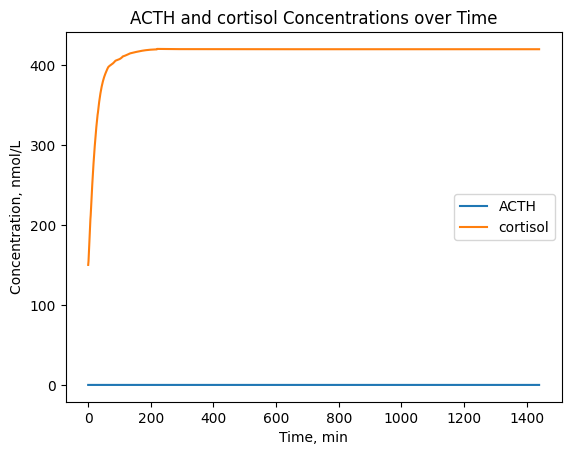

In [ ]:


# Reaction rates
k1 = 1.83  # this is production of ACTH from CRH
k2 = 0.036  # this is the reaction for formation of cortisol from CRH
k3 = 0.000288  # production of ALDO from ACTH
k4 = 1.26 * (10 ** 14)  # more production of CORT from ACTH
k5 = 7.05 * (10 ** 12)  # degradation of cortisol by ALDO
k6 = 0.0535  # this is production of P1 from ACTH
k7 = 0.0410  # this is production of P2 from cortisol, original = 0.410
k8 = 0.11  # production of P3 from CRH
k9 = 0.135  # production of P4 from ALDO

def reaction_system(y, t):
    acth, cort, CRH, ALDO, p1, p2, p3, p4 = y
    dCRH = 1.83 * (10 ** (-8)) - k1 * CRH - k8 * CRH
    dALDO = 6.09 * (10 ** (-11)) + k3 * acth - k5 * ALDO * cort - k9 * ALDO
    dacth_dt = k1 * CRH - k2 * acth - k3 * acth - k4 * acth * cort - k6 * acth
    dcort_dt = k2 * acth + k4 * acth * cort - k7 * cort - k5 * ALDO * cort
    dP1_dt = k6 * acth
    dP2_dt = k7 * cort
    dP3_dt = k8 * CRH
    dP4_dt = k9 * ALDO
    return [dacth_dt, dcort_dt, dCRH, dALDO, dP1_dt, dP2_dt, dP3_dt, dP4_dt]

# Initial concentrations
acth_0 = 0
cort_0 = 150*10**(-9) #the initial condition is 150 nmol/L , which is a reasonable value for cortisol in the morning
CRH_0 = 0
ALDO_0 = 0
p1_0 = 0
p2_0 = 0
p3_0 = 0
p4_0 = 0
y0 = np.array([acth_0, cort_0, CRH_0, ALDO_0, p1_0, p2_0, p3_0, p4_0])

# Time span
t_span = np.linspace(0, 24*60, 24*60)  # Time span from 0 to 10 minutes

# Solve the ODEs
plasma_cortisol = odeint(reaction_system, y0, t_span)
plasma_cortisol_plot = plasma_cortisol[:, 1] * (10**9)
plasma_cortisol_value = plasma_cortisol_plot[-1]
# Plot the results
plt.plot(t_span, plasma_cortisol[:, 0] * (10**9), label='ACTH')
plt.plot(t_span, plasma_cortisol[:, 1] * (10**9), label='cortisol')
plt.xlabel('Time, min')
plt.ylabel('Concentration, nmol/L')
plt.legend()
plt.title('ACTH and cortisol Concentrations over Time')
plt.show()


In [ ]:
print(plasma_cortisol_value)


419.54917403912106


### Glucose in digestive system

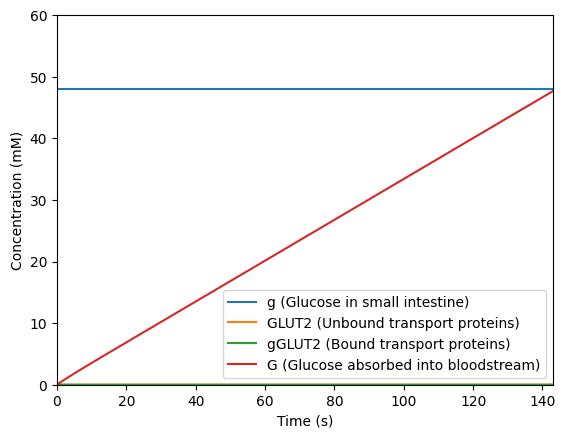

In [ ]:
import numpy as np
from scipy.integrate import odeint


def reversible_reaction(y, t):
  g, GLUT2, gGLUT2, G, C, CGLUT2 = y
  k1 = 550*.100 #mM/s, estimated such that Km is reasonable, between known values of two main transporter proteins (GLUT2 and SGLT1)
  k11 = .050 #mM/s, estimated k-1
  k2 = 550*.307 #mM/s, estimating this as rate needed to get 260 g glucose per day (converted this rate to mmol/s and divided by volume of small intestine interior, .054 L)
  k3 =  1500      #11000.20 #crazy value, but Saterbak approved
  k33 = .050
  #Km = 3.57 mmol/L


  #dg_dt = -k1 * g * GLUT2 + k11 * gGLUT2
  dg_dt = 0
  dGLUT2_dt = -k1 * g * GLUT2 + k11 * gGLUT2 + k2 * gGLUT2 + k33 * CGLUT2 - k3 * GLUT2 * C
  dgGLUT2_dt = k1 * g * GLUT2 - k11 * gGLUT2 - k2 * gGLUT2
  #dG_dt = (k2 * (GLUT2+ gGLUT2) * g) / (g + Km)
  dG_dt = k2 * gGLUT2 #RAHIL - CHANGED TO BE ACCURATE WITH SIMPLIFIED MODEL
  dC_dt = -k3 * C * GLUT2 + k33 * CGLUT2
  dCGLUT2_dt = k3 * C * GLUT2 - k33 * CGLUT2


  return [dg_dt, dGLUT2_dt, dgGLUT2_dt, dG_dt, dC_dt, dCGLUT2_dt]

# Initial conditions
g0 = 48 # mmol/L  # initial concentration of ingested glucose (taken from concentration 2 hours after eating;
                              #I am making the assumption that this is same as average throughout the day)
GLUT20 = .002485 # mmol/L, derived from literature
gGLUT20 = 0.0
G0 = 0
C0 = 5 * 10**-4 # mmol/L, healthy blood cortisol concentration
# C0 = 8 * 10**-4 # mmol/L, cushing's disease blood cortisol concentration
CGLUT20 = 0
y0 = [g0, GLUT20, gGLUT20, G0, C0, CGLUT20]

# Time points
t = np.linspace(0, 86400, 100000)  # Time interval from 0 to 10 with 100 points

# Solve the differential equations
y = odeint(reversible_reaction, y0, t)

# Extract the concentrations
g, GLUT2, gGLUT2, G, C, CGLUT2 = y.T

# Plot the results
import matplotlib.pyplot as plt

plt.plot(t, g, label="g (Glucose in small intestine)")
plt.plot(t, GLUT2, label="GLUT2 (Unbound transport proteins)")
plt.plot(t, gGLUT2, label="gGLUT2 (Bound transport proteins)")
plt.plot(t, G, label="G (Glucose absorbed into bloodstream)")
plt.plot(t = 143)
plt.xlabel("Time (s)")
plt.ylim((0, 60))
plt.xlim((0, 143))
plt.ylabel("Concentration (mM)")
plt.legend()
plt.show()



### Glucose in skeletal muscle

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

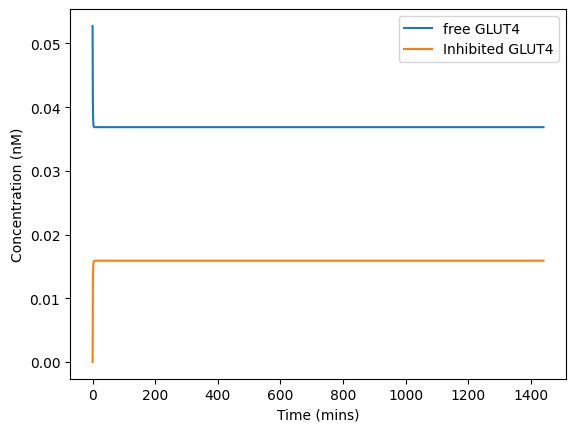

In [ ]:
def reversible_reaction(y, t):
  CORT, R, CR = y
  k_f = 0.054 #nM/min
  k_r = 1 # nM/min

  dCORT_dt = -k_f * CORT * R + k_r * CR
  dRecep_dt = -k_f * CORT * R + k_r * CR
  dC_dt = k_f * CORT * R - k_r * CR
  return [dCORT_dt, dRecep_dt, dC_dt]

# Initial conditions
CORT0 = 400/50  # Initial concentration of Cortisol (nM)
Receptor0 = 0.052750  # Initial concentration of GCs (nM) * 100
C0 = 0.0  # Initial concentration of GC+C
y0 = [CORT0, Receptor0, C0]

# Time points
t = np.linspace(0, 24*60, 24*60)  # Time interval from 0 to 10 with 100 points

# Solve the differential equations
y = odeint(reversible_reaction, y0, t)

# Extract the concentrations
cort, receptor, b_receptor = y.T

# Plot the results
import matplotlib.pyplot as plt

plt.plot(t, receptor, label="free GLUT4")
plt.plot(t, b_receptor, label="Inhibited GLUT4")
plt.xlabel("Time (mins)")
plt.ylabel("Concentration (nM)")
plt.legend()
plt.show()


*   volume of muscle mass is 22.6 L
*   Healthy value of GLUT4 without inhibition:  6.685 (x)



1440


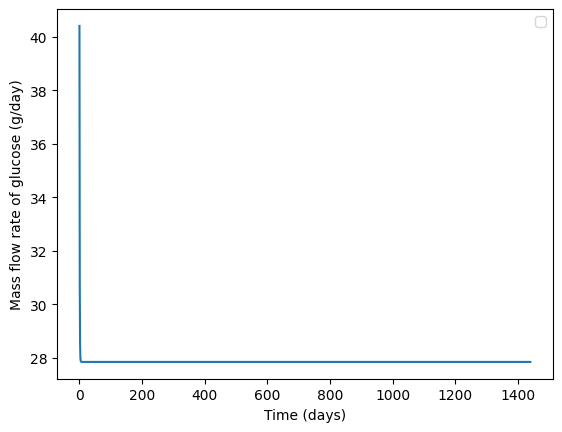

In [ ]:
# how to calculate levels of glucose
GLUT4 = B * 10**(-9) * 22.6 #this is the amount of GLUT4 (in mol)
m_flow_glucose= 3.39*(10**10) * GLUT4 #units are in g/day
print(len(m_flow_glucose))
t = np.linspace(0, 24*60, 24*60)  # Time interval - 1 day
plt.plot(t, m_flow_glucose)
plt.xlabel("Time (days)")
plt.ylabel("Mass flow rate of glucose (g/day)")
plt.legend()
plt.show()

### Adipose tissues

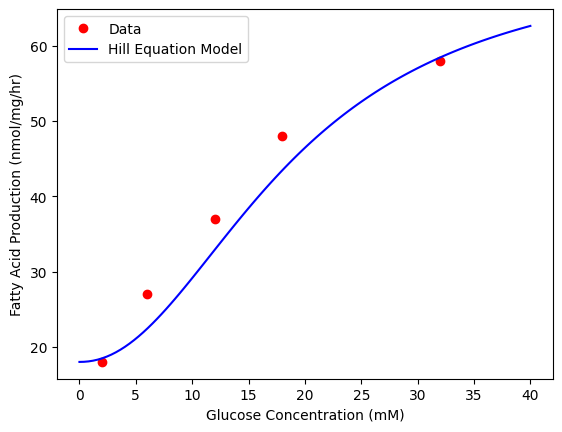

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
glucose = [2, 6, 12, 18, 32]
lipogenesis = [18, 27, 37, 48, 58]

# Hill equation parameters
vmax = 54
k = 19
n = 2.1

# Calculate Hill equation curve
glucose_curve = np.linspace(0, 40, 100)
rate_curve = vmax * (glucose_curve**n / (k**n + glucose_curve**n)) + 18

# Plot data points
plt.plot(glucose, lipogenesis, 'ro', label='Data')

# Plot Hill equation curve
plt.plot(glucose_curve, rate_curve, 'b-', label='Hill Equation Model')

plt.xlabel('Glucose Concentration (mM)')
plt.ylabel('Fatty Acid Production (nmol/mg/hr)')
plt.legend()
plt.show()


### Appendix

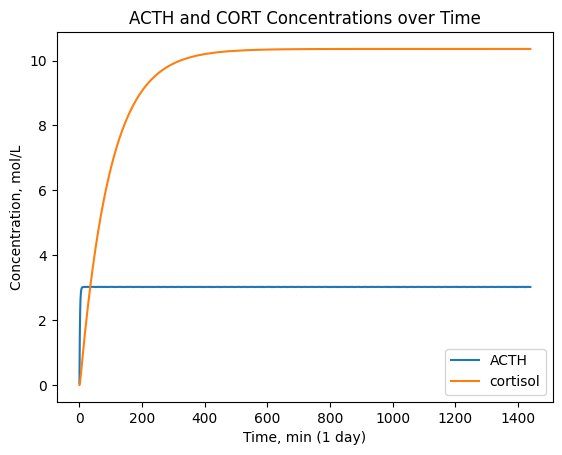

In [ ]:
# Reaction rates

k1 = 1.83 #this is production of ACTH from CRH
k2 = 0.036 #this is the reaction for formation of cortisol
k3 = 0.535 #this is production of P1 from ACTH
k4 = 0.410 #this is production of P2 from cortisol

def reaction_system(t, y):
    acth, cort, p1, CRH  = y

    dacth_dt = k1 * CRH - k2 * acth - k3 * acth - 0.0346 * acth
    dcort_dt = k2 * acth - .0105 * cort
    dP1_dt = k3 * acth
    return [dacth_dt, dcort_dt, dP1_dt, 0]  # 0 indicates that CRH does not change

# Initial concentrations
acth_0 = 0.05
cort_0 = 0.0
P1_0 = 0
CRH_0 = 1
y0 = [acth_0, cort_0, P1_0, CRH_0]

# Time span
t_span = (0, 1440)  # Time span from 0 to 10 minutes

# Solve the ODEs
sol = solve_ivp(reaction_system, t_span, y0, t_eval=np.linspace(0, 1440, 10000))

# Plot the results
plt.plot(sol.t, sol.y[0], label='ACTH')
plt.plot(sol.t, sol.y[1], label='cortisol')
plt.xlabel('Time, min (1 day)')
plt.ylabel('Concentration, mol/L')
plt.legend()
plt.title('ACTH and CORT Concentrations over Time')
plt.show()



# Glucose in the Liver

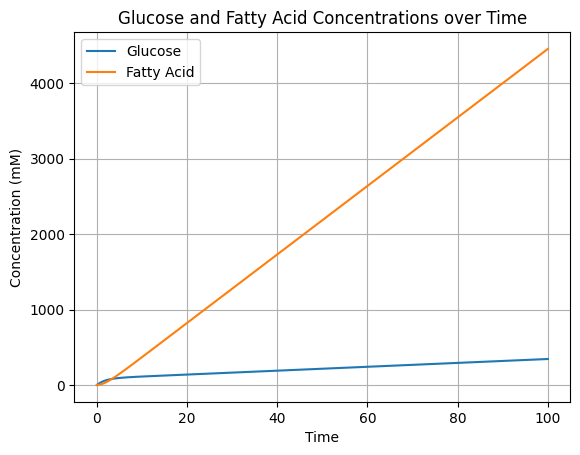

In [ ]:
k1 =  .5 # calculated from the hill model to describe the lipogenesis reaction (glucose -> fatty acid)
Keq = 17.62    # hypothetical equilibrium constant (hr -1 )

k_minus_1 = k1 / Keq

def liver_system(y, t):
    G, F = y
    dGdt = 48 -k1 * G + k_minus_1 * F
    dFdt = k1 * G - k_minus_1 * F
    return [dGdt, dFdt]

G0 = 0 # mM initial value
F0 = 0   # mM initial value

y0 = [G0, F0]
t = np.linspace(0, 100, 1000)  # Time vector

# Solve ODE
sol = odeint(liver_system, y0, t)

# Plot results
plt.plot(t, sol[:, 0], label='Glucose')
plt.plot(t, sol[:, 1], label='Fatty Acid')
plt.xlabel('Time')
plt.ylabel('Concentration (mM)')
plt.title('Glucose and Fatty Acid Concentrations over Time')
plt.legend()
plt.grid(True)
plt.show()


# Fatty acid in Adipose tissue (?)


Notes have it just passing through adipose tissues
should have a build up of triglycerides in it from reacting equation


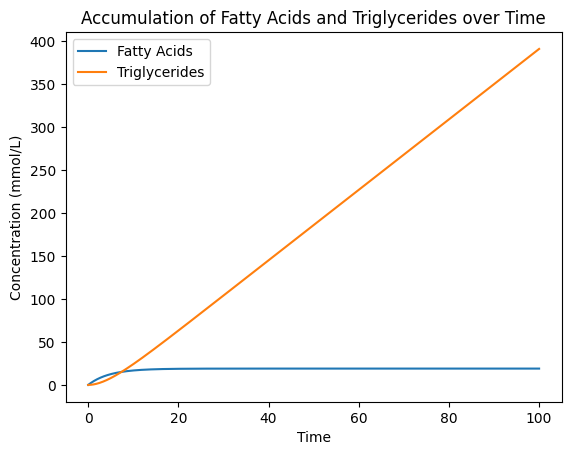

In [ ]:
## reation [fatty acid] -> [triglyceride]
## attempt to create the dynamic system that combines all compartments code

# Rate constant
k = .21565

# Define the differential equation system
def model(y, t):
    FA, TG = y
    dFA_dt = 4.1 -k * FA  # Rate of change of fatty acids
    dTG_dt = k * FA   # Rate of change of triglycerides
    return [dFA_dt, dTG_dt]

# Initial conditions
y0 = [0, 0]  # Initial concentrations of fatty acids and triglycerides (mmol/L)

# Time points to solve for
t = np.linspace(0, 100, 1000)  # 1000 time points from 0 to 100

# Solve the ODE
y = odeint(model, y0, t)

# Extracting results
FA_concentrations = y[:, 0]
TG_concentrations = y[:, 1]

# Plotting
plt.plot(t, FA_concentrations, label='Fatty Acids')
plt.plot(t, TG_concentrations, label='Triglycerides')
plt.xlabel('Time')
plt.ylabel('Concentration (mmol/L)')
plt.title('Accumulation of Fatty Acids and Triglycerides over Time')
plt.legend()
plt.show()

